In [423]:
# Only need this cell if you are using jupyter lab. Change path as needed
#%cd /data/wesley/Milestone_Error_Analysis_Testing
#!ls

/data/wesley/Milestone_Error_Analysis_Testing
Milestone_Polynomial_Model_Test.ipynb  analysis_functions.py
README.md			       asymmetric_case.raw_trajectory_data.csv
Untitled.ipynb			       symmetric_case.raw_trajectory_data.csv


In [393]:
import numpy as np
import pandas as pd
import matplotlib

from matplotlib import pyplot as plt
import seaborn as sns

import plotly as ply

import tqdm
import gc
import sys
import os

import scipy as sp

# Define Simple 1 Dimensional 1 Particle Brownian Dynamics Simulation

In [394]:
class Simple_1D_BD_Sim:
    def __init__(
        self, 
        potential_gradient_function,
        parameter_dict=None, 
        starting_coordinates=0, #technically 'coordinate' since this is 1D #1D function,takes a coordinate (x) and yields grad(U(x)). I.e. dU/dx
    ):
        self.kb=0.001985875 #kcal/(mol*K)
        self.parameter_dict=dict(
            diffusionConstant=1.0, #in Å**2*kcal/(mol*fs) -> i.e. square distance * energy per (mol) time unit
            temperature=310.15, # Kelvins (default = normal body temperature),
            vmax=1.5, #maximum allowed velocity (violation will terminate simulation due to instability)
            trajectorySnapshotRate=100, #number of steps between saving to trajectory data
            periodicBoundaryLength=None,
            verbose=False,
        )
        if not (parameter_dict is None):
            self.set_parameters(parameter_dict)
        if not (starting_coordinates is None):
            self.x0=starting_coordinates
        else:
            self.x0=0
            
        self.set_potential_gradient_function(potential_gradient_function)
        
        
    def set_parameters(self,parameter_dict):
        for parameterName in parameter_dict:
            if parameterName in self.parameter_dict: #make sure we dont add unsupported parameters
                self.parameter_dict[parameterName]=parameter_dict[parameterName]
            elif self.parameter_dict['verbose']:
                print('Warning: parameter "%s" not supported'%(str(parameterName)))
    
    def set_potential_gradient_function(self,potential_gradient_function):
        self.potential_gradient_function=potential_gradient_function
   
    def set_x0(self,x0):
        self.x0=x0
        
    def run_sim(
        self,
        nsteps=10000,
        giveVelocities=False,
        randomSeed=None,
        pbar=None,
    ):
        
        x=self.x0
        bPBL=self.parameter_dict['periodicBoundaryLength']
        if not (bPBL is None):
            x=x%bPBL
        bD=self.parameter_dict['diffusionConstant']
        kb=self.kb
        bT=self.parameter_dict['temperature']
        trajInterval=self.parameter_dict['trajectorySnapshotRate']
        verbose=self.parameter_dict['verbose']
        bVmax=self.parameter_dict['vmax']
        gradUfun=self.potential_gradient_function
        print(nsteps)
        if not (randomSeed is None): #in case we want to specify a specific random seed for reproducibility
            np.random.seed(randomSeed)
        trajectoryData=np.zeros(int(nsteps/trajInterval))
        if giveVelocities:
            velocityData=np.zeros(nsteps)
        
        tStep=0    
        stable=True
        # X'(t)=-D/(kbT)*grad(U(X))+√(2D)*R(t)
        #R -> stationary gaussian process
        while (tStep<nsteps) and stable:
            v=-bD/(kb*bT)*gradUfun(x)+np.sqrt(2*bD)*np.random.standard_normal()
            if (tStep%trajInterval) == 0:
                trajectoryData[int(tStep/trajInterval)]=x
                if giveVelocities:
                    velocityData[int(tStep/trajInterval)]=v
            if np.abs(v)>bVmax:
                stable=False
                if verbose:
                    print(
                        ("ERROR (step %g): velocity (%.3e) exceeds maximum (%.3e),"+\
                        "simulation terminated due to instability")%(
                            tStep,v,bVmax
                        )
                    )
            if not pbar is None:
                pbar.update()
            x=x+v
            if not (bPBL is None):
                x=x%bPBL
            tStep=tStep+1
        outDict=dict(
            trajectory=trajectoryData[:(int(tStep/trajInterval)+1)]
        )
        if giveVelocities:
            outDict['velocities']=velocityData[:(int(tStep/trajInterval)+1)]
        return(outDict)

## Simple symetric case

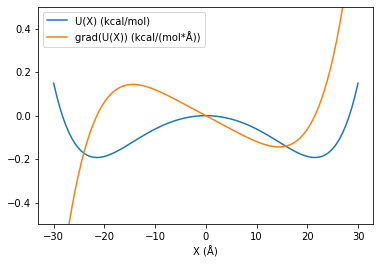

In [395]:
def potFun(x):
    return(1.0/1024.0*(x/10.)**6-.0625*(x/10.)**2)
def potGradFun(x):
    return(6.0/1024.0*(x/10.)**5-.125*(x/10.))

xgrid=np.linspace(-30,30,101)
sns.lineplot(
    x=xgrid,
    y=potFun(xgrid),
    label='U(X) (kcal/mol)'
)
sns.lineplot(
    x=xgrid,
    y=potGradFun(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)
plt.ylim(-.5,.5)
plt.xlabel('X (Å)')
plt.show()

In [398]:
#Air(g)-water(g) diffusion constant: .282 cm**2/s (at 25 ºC)
# -> (10**-8)**2/10**-15 = 10**-1 Å**2/fs per cm**2/s
# so Air-water = .0282 Å**2/fs
diffCoef=.0282*310.15/298.15 #Approximate scaling to body temperature 

bd_Sim=Simple_1D_BD_Sim(potGradFun)
bd_Sim.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=15.0,
    trajectorySnapshotRate=1000,
    verbose=True,
))
bd_Sim.set_x0(-25.)

In [399]:
display('x0=%f'%bd_Sim.x0)
bd_Sim.parameter_dict

'x0=-25.000000'

{'diffusionConstant': 0.02933499916149589,
 'temperature': 310.15,
 'vmax': 15.0,
 'trajectorySnapshotRate': 1000,
 'periodicBoundaryLength': None,
 'verbose': True}

In [400]:
nsteps=100000000
trajData=bd_Sim.run_sim(nsteps=nsteps,pbar=tqdm.tqdm_notebook(total=nsteps))

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


100000000


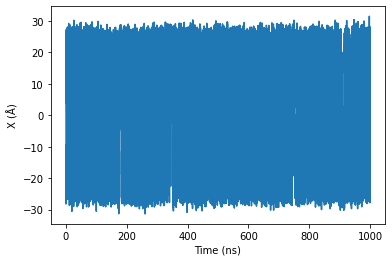

In [401]:
sns.lineplot(
    x=np.arange(len(trajData['trajectory']))*.01,
    y=trajData['trajectory']
)
plt.ylabel('X (Å)')
plt.xlabel('Time (ns)')
plt.show()

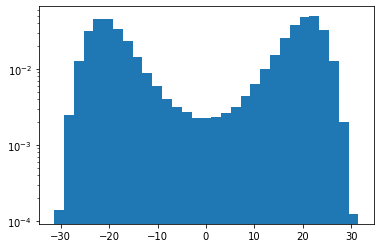

In [402]:
plt.hist(
    x=trajData['trajectory'],
    bins=31,
    density=True,
    log=True
)
plt.show()

In [403]:
np.histogram(trajData['trajectory'],bins=np.linspace(-30,30,31))

(array([  224,  1548,  4818,  8492,  9585,  7702,  5566,  3541,  2226,
         1416,   946,   722,   557,   475,   473,   456,   490,   562,
          726,   993,  1521,  2377,  3727,  5869,  8368, 10092,  9252,
         5326,  1710,   218]),
 array([-30., -28., -26., -24., -22., -20., -18., -16., -14., -12., -10.,
         -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.,  12.,
         14.,  16.,  18.,  20.,  22.,  24.,  26.,  28.,  30.]))

In [404]:
trajTable=pd.DataFrame(dict(
    Time=np.arange(len(trajData['trajectory'])),
    X=trajData['trajectory']
))
if 'velocities' in trajData:
    trajTable['V']=trajData['velocities']
    
display(trajTable.head())
trajTable.to_csv('symmetric_case.raw_trajectory_data.csv')

,Time,X
0,0,-25.000000
1,1,-24.998660
2,2,-15.894602
3,3,-13.826689
4,4,-22.487863


## Simple Asymmetric Case

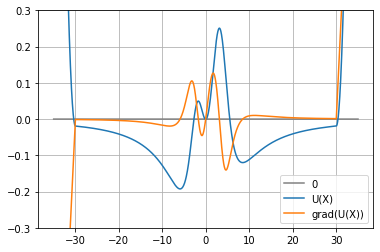

In [405]:
tempx=np.linspace(-35,35,1401)
def potFun2(x):
    return -.5*(((tempx-.67)/3.)**4-4)/(((tempx-.67)/3.)**4+4) + \
            .5*((tempx/3.)**2-2)/((tempx/3.)**2+2)+ \
            .125*(x>30.0)*(30.-x)**2 + \
            .125*(x<-30.0)*(-30.-x)**2

def potGradFun2(x):
    return ((36* x**9 - 192.96* x**8 - 843.509* x**7 + 1998.62* x**6 - 24565.5* x**5 + \
         31377.1* x**4 - 419813.* x**3 + 829957.* x**2 + 3.21835E6* x + 126292.)/ \
        ((x**2 + 18)**2 *(x**4 - 2.68* x**3 + 2.6934* x**2 - 1.20305* x + 324.202)**2)) - \
        .250*(x>30.0)*(30.-x) - .250*(x<-30.)*(-30.-x)

sns.lineplot(x=tempx,y=tempx*0.,label=0,color='grey')
sns.lineplot(x=tempx,y=potFun2(tempx),label="U(X)")
sns.lineplot(x=tempx,y=potGradFun2(tempx),label="grad(U(X))")
plt.ylim(-.3,.3)
plt.grid()
plt.show()

In [406]:
#Air(g)-water(g) diffusion constant: .282 cm**2/s (at 25 ºC)
# -> (10**-8)**2/10**-15 = 10**-1 Å**2/fs per cm**2/s
# so Air-water = .0282 Å**2/fs
diffCoef=.0282*310.15/398.15 #Approximate scaling to body temperature 

bd_Sim2=Simple_1D_BD_Sim(potGradFun2)
bd_Sim2.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=100.0,
    trajectorySnapshotRate=1000,
    verbose=True,
))
bd_Sim2.set_x0(-25.)

In [407]:
display('x0=%f'%bd_Sim2.x0)
bd_Sim2.parameter_dict

'x0=-25.000000'

{'diffusionConstant': 0.021967173175938715,
 'temperature': 310.15,
 'vmax': 100.0,
 'trajectorySnapshotRate': 1000,
 'periodicBoundaryLength': None,
 'verbose': True}

In [408]:
nsteps=100000000
trajData2=bd_Sim2.run_sim(
    nsteps=nsteps,
    giveVelocities=True,
    pbar=tqdm.tqdm_notebook(total=nsteps))

/home/wesley/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


100000000


In [409]:
trajData2

{'trajectory': array([-25.        , -12.76437521, -14.87500758, ..., -19.23660815,
        -25.2221135 , -17.32623955]),
 'velocities': array([ 0.00327625,  0.03208498, -0.22129826, ..., -0.06361546,
        -0.03329538,  0.        ])}

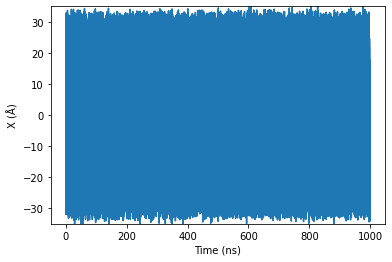

In [410]:
sns.lineplot(
    x=np.arange(len(trajData2['trajectory']))*.01,
    y=trajData2['trajectory']
)
plt.ylabel('X (Å)')
plt.xlabel('Time (ns)')
plt.ylim(-35,35)
plt.show()

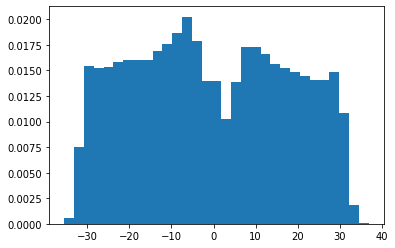

In [411]:
plt.hist(
    x=trajData2['trajectory'],
    bins=31,
    density=True,
    #log=True
)
plt.show()

In [412]:
np.histogram(trajData2['trajectory'],bins=np.linspace(-30,30,31))

(array([3098, 3077, 3089, 3121, 3225, 3140, 3229, 3246, 3420, 3484, 3715,
        4002, 3888, 3111, 2850, 2702, 2059, 2576, 3317, 3552, 3375, 3350,
        3061, 3068, 2993, 2867, 2870, 2788, 2848, 2973]),
 array([-30., -28., -26., -24., -22., -20., -18., -16., -14., -12., -10.,
         -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.,  12.,
         14.,  16.,  18.,  20.,  22.,  24.,  26.,  28.,  30.]))

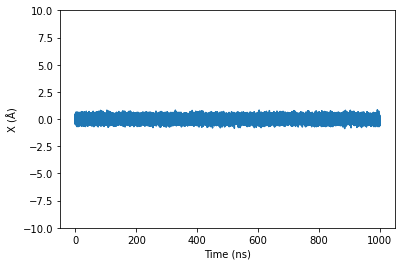

In [413]:
sns.lineplot(
    x=np.arange(len(trajData2['velocities']))*.01,
    y=trajData2['velocities']
)
plt.ylabel('X (Å)')
plt.xlabel('Time (ns)')
plt.ylim(-10,10)
plt.show()

In [416]:
trajTable2=pd.DataFrame(dict(
    Time=np.arange(len(trajData2['trajectory'])),
    X=trajData2['trajectory']
))
if 'velocities' in trajData2:
    trajTable2['V']=np.array(trajData2['velocities'])[:len(trajTable2)]
    
display(trajTable2.head())
trajTable2.to_csv('asymmetric_case.raw_trajectory_data.csv')

,Time,X,V
0,0,-25.000000,0.003276
1,1,-12.764375,0.032085
2,2,-14.875008,-0.221298
3,3,-24.724078,-0.176363
4,4,-12.695849,0.000143


# Load and Analyze Trajectory Data

## Symmetric Case

In [425]:
import analysis_functions

In [418]:
symmData=pd.read_csv("symmetric_case.raw_trajectory_data.csv")
symmData=symmData.drop(columns=symmData.columns[0])
symmData.head()

,Time,X
0,0,-25.000000
1,1,-24.998660
2,2,-15.894602
3,3,-13.826689
4,4,-22.487863


In [438]:
binEdges=np.linspace(-25,25,26)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
print(
    "binEdges = %s"%binEdges + "\nbinCenters = %s"%binCenters
)
symmData['X_Ind']=symmData['X'].apply(
    lambda x: np.argmin(np.abs(x-binCenters))
)
symmData.head()

binEdges = [-25. -23. -21. -19. -17. -15. -13. -11.  -9.  -7.  -5.  -3.  -1.   1.
   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.  23.  25.]
binCenters = [-24. -22. -20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.
   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.]


,Time,X,X_Ind
0,0,-25.000000,0
1,1,-24.998660,0
2,2,-15.894602,4
3,3,-13.826689,5
4,4,-22.487863,1
